# 1. Mixed Marketing Modelling (MMM)

## A) Problem Statement
* In the marketing funnel stages: awareness, consideration, engagement, and conversion.
* Marketers aim to quantify the impact of their investments across various channels on key performance indicators (KPIs). Desired features in a marketing tool includes:
    * Ability to set spending limits for specific channels or the aggregates.
    * Integration of domain expertise and contextual factors like seasonality and promotional activities.

### i) Solution
* **Input Data:** Spendings across different channels, baseline KPIs (such as sales or conversions), and contextual variables like seasonality and promotions.
* **Model**: A Bayesian regression model is highly effective for comprehensive parameter estimation.
* **Workflow**:
    * Data cleansing.
    * Implementation of adstock for capturing lag effects.
    * Transforming media variables with response curve functions.
    * Constructing a Bayesian regression model using CmdStan.
* **Analytics**:
    * Generation of insightful findings.
    * Assessment of contributions to KPIs.
    * Visualization of response curves for each channel (KPI vs. spending)
    * Strategic budget allocation.

### ii) QnA - Why Bayesian Model?
* **Input Data**:
    * 1) Historical spends across media channels, and other variables, and KPI variable
    * 2) Configuration files - priors settings
* **Highly effective** for comprehensive parameter estimation.
* **Fully customizable** - based on user's belief and prior domain knowledge.
* **Generic** and applicable for various scenarios.
* **Insights generation**.

In [12]:
import os
import json
import glob
import cmdstanpy
import pandas as pd
import numpy as np
import seaborn as sns

from cmdstanpy import CmdStanModel, CmdStanMCMC

import matplotlib.pyplot as plt

from engine.util.stan_code_helper import create_stan_function_block, create_stan_data_block, create_stan_parameters_block, create_stan_model_block, create_stan_transformed_parameters_block
from engine.util.prepare_workflow import prepare_stan_data
from engine.util.evaluation import geweke

DIR = "model_output"

In [42]:
# Sample data: https://bit.ly/400xhP6
data_df = pd.read_csv('data/data.csv', parse_dates=['date'])
config_df = pd.read_csv('data/config.csv')

## B) Explanatory Data Analysis (EDA)

### i) Components
* The dataset features daily granularity with the following components:
    * **Key Performance Indicator (KPI)**: **Revenue**.
    * **Base Variables**: Includes base_revenue (comprises of factors such as **seasonality, promotion, historical sales**), representing fundamental business metrics
    * **Media Spend Variables**: Comprises **advertising expenses** across various platforms including Google, Facebook, influencers, and traditional channels like TV, radio, and magazine.
    * The dataset encompasses 365 rows, providing a comprehensive annual view.

In [3]:
data_df.head()

,date,revenue,base_revenue,google_performance_max,google_search_brand,google_search_no_brand,facebook_conversions,facebook_others,facebook_product_catalog_sales,influencers,display_ads,tv_ads,radio_ads,magazine_ads
0,2022-01-01,5796.714153,4309.984889,565.844985,322.220135,1362.108867,163.379921,152.275251,585.579521,486.459433,1326.028990,1702.230023,166.876823,599.465584
1,2022-01-02,5165.863043,4058.650572,458.498491,232.034662,1217.779342,240.671009,572.280788,367.558630,181.465092,761.528524,1082.458280,127.253406,319.817106
2,2022-01-03,6965.648769,4120.744363,673.987247,351.658849,1723.328306,777.660821,646.790367,443.272047,413.778807,421.681361,630.103186,192.637981,282.768261
3,2022-01-04,5710.922590,4101.065750,600.195659,253.768143,688.169972,580.639485,545.659219,375.149632,190.269984,244.705077,2318.640804,166.475016,412.040813
4,2022-01-05,4371.813951,2999.680601,456.867519,255.514027,835.129990,332.607431,449.809561,363.454579,294.213237,552.753741,2157.475018,127.684970,184.554535


### ii) Checking missing data

In [4]:
# Summarize missing data
missing_data_summary = data_df.isnull().sum()
missing_data_summary.name = 'missing_data_count'

print("Missing Data Summary:")
missing_data_summary

Missing Data Summary:


date                              0
revenue                           0
base_revenue                      0
google_performance_max            0
google_search_brand               0
google_search_no_brand            0
facebook_conversions              0
facebook_others                   0
facebook_product_catalog_sales    0
influencers                       0
display_ads                       0
tv_ads                            0
radio_ads                         0
magazine_ads                      0
Name: missing_data_count, dtype: int64

### iii) Correlation plot
* Observed:
    * Revenue is **highly correlated** to base_revenue, google ads, facebook product catalog sales, radio ads

<Axes: >

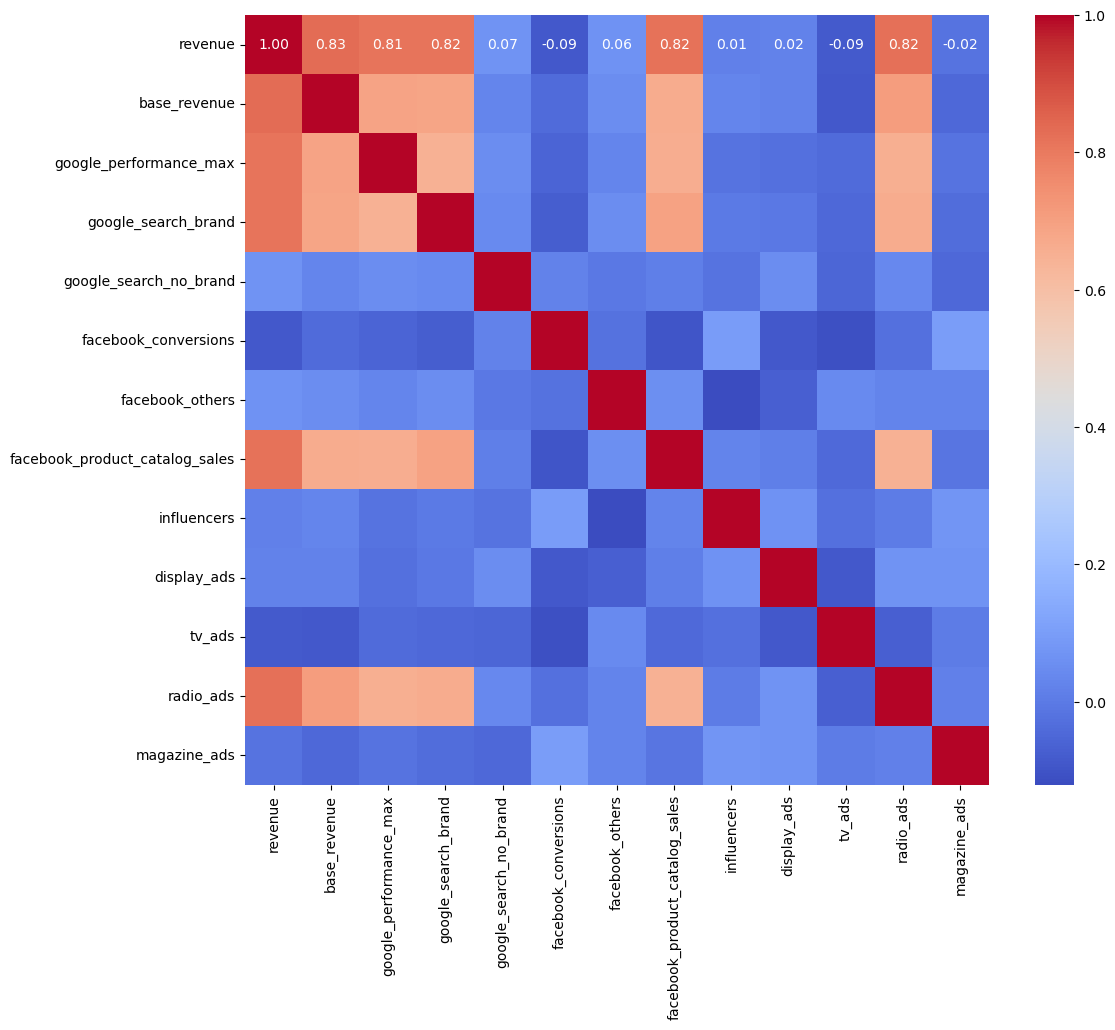

In [5]:
corr = data_df.drop(columns=['date']).corr()
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

## C) Modify Spend data to include adstock effect

### i) Adstock introduction
* Adstock, also known as **advertising carry-over** or **media carry-over effect**.
* The effect of advertising does not stop immediately after the ad is shown; instead, it diminishes or "decays" over time.
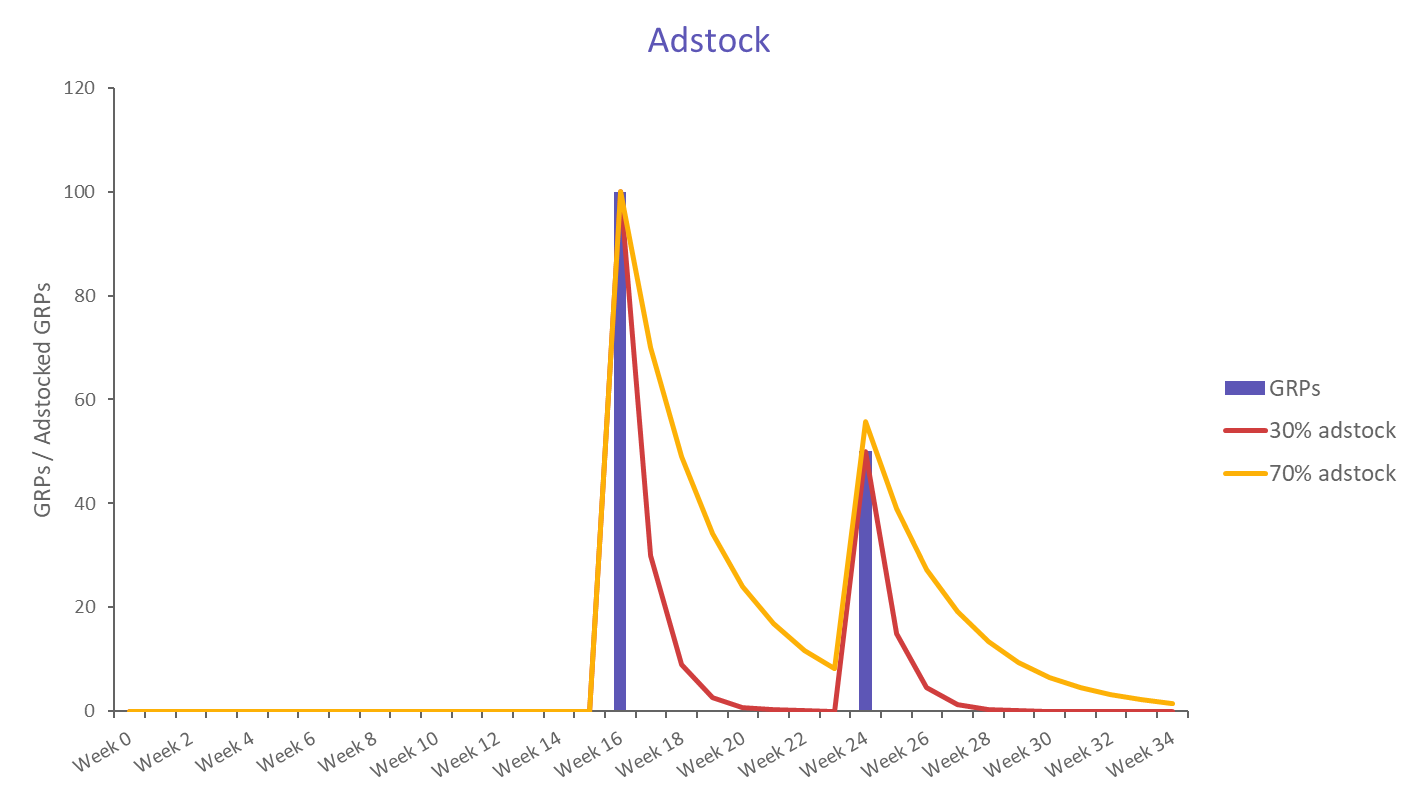


### ii) Another assumption - fixed adstock across channel
* It can be accounted into Bayesian modelling, however, it would take too much time to compute a single value for one media.
* Solution is to act as prior: hardcode a typical value of 20%.
* Adstock model: geometric model.

In [6]:
import pandas as pd

def apply_adstock(dataframe, adstock_rate=0.2):
    adstocked_dataframe = pd.DataFrame(index=dataframe.index)
    
    # Loop through each column in the dataframe and apply the adstock transformation
    for column in dataframe.columns:
        # Initialize the first adstocked value to the first value in the column
        adstocked_values = [dataframe[column].iloc[0]]
        
        # Loop through the remaining values and apply the adstock formula
        for i in range(1, len(dataframe[column])):
            adstocked_value = dataframe[column].iloc[i] + (adstocked_values[i-1] * adstock_rate)
            adstocked_values.append(adstocked_value)
        
        # Assign the adstocked values to the new DataFrame
        adstocked_dataframe[column] = adstocked_values
    
    return adstocked_dataframe


data_df_media = data_df[[col for col in config_df[config_df['Category'] == 'MEDIA'].Variable.tolist()]]
data_df_non_media = data_df[[col for col in data_df if col not in data_df_media.columns]]

# Adstocked-data
data_df_adstocked = pd.concat([data_df_non_media, apply_adstock(data_df_media)], axis=1)

## D) Response curves for channels

### i) Definition
* This describes the relationship beteween **spending and KPI** for each channel.
* We are using the famous 3-parameter pystan hill curves

### ii) Parameter Explanation
* $$
hill = \beta \times \frac{x^A}{x^A + B^A}
$$

where the parameters represent:  
* **β (Maximum Response)**: Scaling effect, the maximum potential effect or conversion that could be achieved by the advertising channel. 
* **A (Hill Coefficient)**: Steepness of the curve or the cooperation level.
* **B (Half Saturation Point)**: Concentration of the stimulus at which the response is half of β.

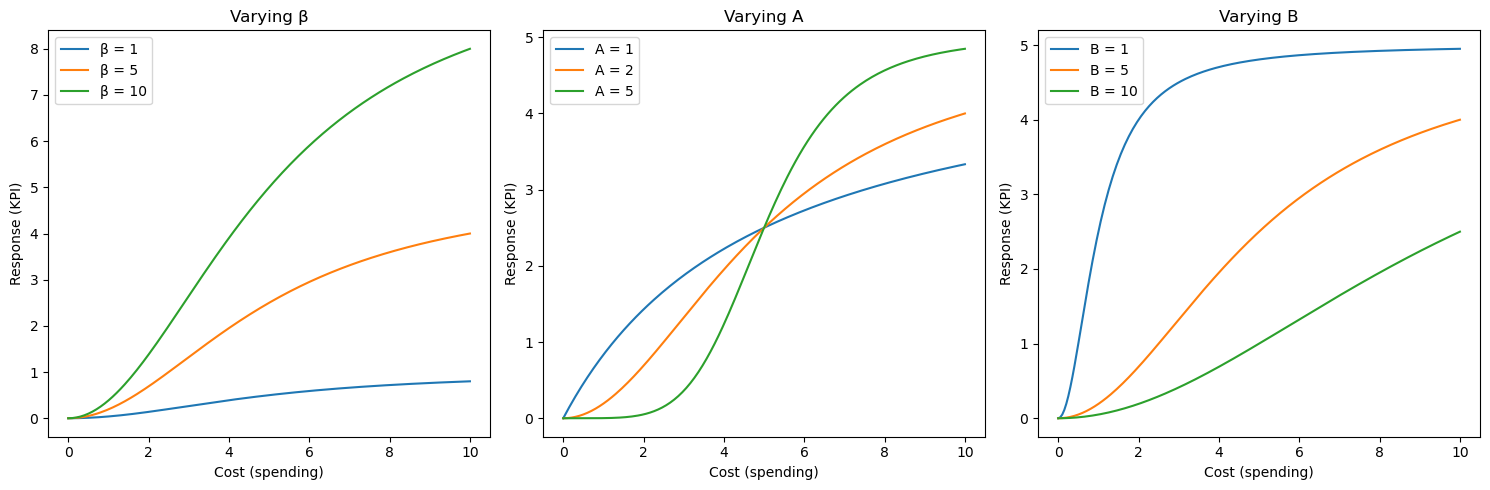

In [41]:
# Define the Hill function
def hill_function(x, beta, A, B):
    return beta * (x**A) / ((x + 1e-9)**A + B**A)

# Set up a range for x
x_values = np.linspace(0, 10, 200)

# Scenario 1: Varying β (max response)
beta_values = [1, 5, 10]
A_constant = 2
B_constant = 5

plt.figure(figsize=(15, 5))

# Plotting varying β
plt.subplot(1, 3, 1)
for beta in beta_values:
    plt.plot(x_values, hill_function(x_values, beta, A_constant, B_constant), label=f'β = {beta}')
plt.title('Varying β')
plt.xlabel('Cost (spending)')
plt.ylabel('Response (KPI)')
plt.legend()

# Scenario 2: Varying A (Hill coefficient)
A_values = [1, 2, 5]
beta_constant = 5

# Plotting varying A
plt.subplot(1, 3, 2)
for A in A_values:
    plt.plot(x_values, hill_function(x_values, beta_constant, A, B_constant), label=f'A = {A}')
plt.title('Varying A')
plt.xlabel('Cost (spending)')
plt.ylabel('Response (KPI)')
plt.legend()

# Scenario 3: Varying B (EC50)
B_values = [1, 5, 10]

# Plotting varying B
plt.subplot(1, 3, 3)
for B in B_values:
    plt.plot(x_values, hill_function(x_values, beta_constant, A_constant, B), label=f'B = {B}')
plt.title('Varying B')
plt.xlabel('Cost (spending)')
plt.ylabel('Response (KPI)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


## E) Prepare MMM Prior inputs

### i) Assumptions
* Some assumptions are:
    * The marketers have **flat** knowledge about all the potential values (High variance, allow flexibility)
    * Assuming **Google/Facebook** would be able to reach **higher maximum of revenue (Hige beta)**. 
    * **Flat steepness** across all the media channels **(Constant parameter A)**.
    * For traditional media channel such as TV, radio - it's assumed that they have higher budget is required to achieve the same target. **(High parameter B)**
 
### ii) Sample configs

In [8]:
config_df

,Variable,Category,Prior,Beta_Init,Beta_Min,Beta_Max,Parameter_A_Init,Parameter_A_Min,Parameter_A_Max,Parameter_B_Init,Parameter_B_Min,Parameter_B_Max
0,revenue,KPI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,base_revenue,BASE,10000.0,1.0,0.1,1000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,google_performance_max,MEDIA,10000.0,10.0,0.1,1000.0,1.0,0.1,2.0,2.0,0.1,1000.0
3,google_search_brand,MEDIA,10000.0,10.0,0.1,1000.0,1.0,0.1,2.0,2.0,0.1,1000.0
4,google_search_no_brand,MEDIA,10000.0,10.0,0.1,1000.0,1.0,0.1,2.0,2.0,0.1,1000.0
5,facebook_conversions,MEDIA,10000.0,5.0,0.1,1000.0,1.0,0.1,2.0,2.0,0.1,1000.0
6,facebook_others,MEDIA,10000.0,5.0,0.1,1000.0,1.0,0.1,2.0,2.0,0.1,1000.0
7,facebook_product_catalog_sales,MEDIA,10000.0,5.0,0.1,1000.0,1.0,0.1,2.0,5.0,0.1,1000.0
8,influencers,MEDIA,10000.0,5.0,0.1,1000.0,1.0,0.1,2.0,5.0,0.1,1000.0
9,display_ads,MEDIA,10000.0,1.0,0.1,1000.0,1.0,0.1,2.0,30.0,0.1,1000.0


## F) MMM Model Formulation
* In summary: It's an **customizable additive model combining cost of each media channels + contextual variables.**
* Where contextual variables were linearly dependent, media channels were following some hill curve transformations.
 
### i) Formula
$$
\begin{align*}
\text{Revenue (KPI)} &= \text{Base Variables Contribution} + \text{Media Variables Contribution} + \epsilon \\
&= \sum \left(\beta_{\text{base}} \times x_{\text{base}}\right) + \sum \left( \text{Hill}(\text{Adstock}(x_{\text{media}}), \beta_{\text{media}}, A_{\text{media}}, B_{\text{media}}) \right) + \epsilon \\
\end{align*}
$$

### ii) Stan code

$$
\begin{align*}
&\text{Functions:} \\
&\quad \text{Generic Hill function: } \text{hill\_function}(x, \beta, A, B) = \frac{\beta \cdot x^A}{x^A + B^A} \\
&\text{Parameters:} \\
&\quad \beta_{\text{base}_{i}} \text{ (bound: lower, upper)} \\
&\quad \beta_{\text{media}_{i}}, \text{ (bound: lower, upper)} \\
&\quad \text{param\_A}_{\text{media}_{i}} \text{ (bound: lower, upper)} \\
&\quad \text{param\_B}_{\text{media}_{i}} \text{ (bound: lower, upper)} \\
&\quad \sigma \\
&\text{Transformed Parameters:} \\
&\quad \mu = \text{rep\_vector}(0, N) \\
&\quad \text{for } n \text{ in } 1:N: \\
&\quad \quad \mu[n] += \beta_{\text{base}_{i}} \cdot \text{base}_{i}[n] \\
&\quad \quad \mu[n] += \text{hill\_function}(\text{media}_{i}[n], \beta_{\text{media}_{i}}, \text{param\_A}_{\text{media}_{i}}, \text{param\_B}_{\text{media}_{i}}) \\
&\text{Model:} \\
&\quad \beta_{\text{base}_{i}} \sim \text{normal}(\mu_{{base}_{i}}, \sigma_{{base}_{i}}) \\
&\quad \beta_{\text{media}_{i}} \sim \text{normal}(\mu_{{media}_{i}}, \sigma_{{media}_{i}}) \\
&\quad \text{param\_A}_{\text{media}_{i}} \sim \text{normal}(\mu_{\text{param\_A}_{\text{media}_{i}}}, \sigma_{\text{param\_A}_{\text{media}_{i}}}) \\
&\quad \text{param\_B}_{\text{media}_{i}} \sim \text{normal}(\mu_{\text{param\_B}_{\text{media}_{i}}}, \sigma_{\text{param\_B}_{\text{media}_{i}}}) \\
&\quad \sigma \sim \text{cauchy}(0, 2) \\
&\quad \text{for } n \text{ in } 1:N: \\
&\quad \quad \text{revenue}[n] \sim \text{normal}(\mu[n], \sigma) \\
\end{align*}
$$

### iii) Prepare modelling stan code

In [9]:
# Create stan blocks for function, data, parameters, and model
function_block = create_stan_function_block()
stan_data_block_code = create_stan_data_block(config_df)
stan_parameters_code = create_stan_parameters_block(config_df)
stan_transformed_parameters_code = create_stan_transformed_parameters_block(config_df)
stan_model_code = create_stan_model_block(config_df)

prepare_stan_data(data_df_adstocked)

In [10]:
# Compile the model
model_code = "\n".join([function_block, stan_data_block_code, stan_parameters_code, stan_transformed_parameters_code, stan_model_code])
with open('model.stan', 'w') as file:
    file.write(model_code)

In [11]:
model = CmdStanModel(stan_file='model.stan')

13:34:30 - cmdstanpy - INFO - compiling stan file C:\Users\User\mmm-toolbox\model.stan to exe file C:\Users\User\mmm-toolbox\model.exe
13:34:48 - cmdstanpy - INFO - compiled model executable: C:\Users\User\mmm-toolbox\model.exe


### iv) Hyperparameters setting for HMC-NUTS sampler
* Hyperparameters include:
    * **Chains**: Number of parallel chains to run.
    * **Warm-up iteration**: Discarded initial iterations for adaptation.
    * **Sampling iteration**: Collecting statistics and samples.
    * **Max tree depth**: Controls leapfrog steps in NUTS.
    * **Adapt delta**: Step size adjustment during warm-up.

In [16]:
# run the NUTS-HMC sampler
stan_fit = model.sample(data='stan_data.json', 
                        parallel_chains=4, 
                        iter_warmup=500, 
                        iter_sampling=5000, 
                        max_treedepth=10,
                        adapt_delta=0.80)

11:58:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:12:01 - cmdstanpy - INFO - CmdStan done processing.


### v) Save/persist the model in the form of CSVs

In [17]:
stan_fit.save_csvfiles(dir=DIR)

CmdStanMCMC: model=model chains=4['method=sample', 'num_samples=5000', 'num_warmup=500', 'algorithm=hmc', 'engine=nuts', 'max_depth=10', 'adapt', 'engaged=1', 'delta=0.8']
 csv_files:
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_1.csv
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_2.csv
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_3.csv
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_4.csv
 output_files:
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_0-stdout.txt
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_1-stdout.txt
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_2-stdout.txt
	C:\Users\User\AppData\Local\Temp\tmpxz9a4hkn\model8_5obym7\model-20240127115827_3-stdout.txt

In [9]:
# To reload: 
csv_files = glob.glob(os.path.join(DIR, '*.csv'))
stan_fit = cmdstanpy.from_csv(csv_files)

In [10]:
fit_result = stan_fit.summary()
fit_result_dict = fit_result.Mean.to_dict()

In [13]:
fit_result.to_csv("fit_result.csv")
with open("fit_result_dict.json", "w") as f:
    json.dump(fit_result_dict, f)

## G) Model Evaluation

### i) Geweke's statistics
* If the samples are drawn from a stationary distribution of the chain, then the two means are equal.
* Z-scores close to 0 (typically within -2 to +2) across intervals suggest that the chain has converged for that parameter. 
* Large absolute Z-scores (far from 0, especially beyond -2 or +2) might indicate lack of convergence, suggesting that the chain has not adequately explored the posterior distribution.

In [14]:
param_names = stan_fit.stan_variables()  # Get all parameter names
traces = {param: stan_fit.stan_variable(param) for param in param_names}
geweke_scores = {param: geweke(trace, intervals=5, length=0.5, first=0.1) for param, trace in traces.items()}

[var for var, scores in geweke_scores.items() if any(np.abs(scores)) > 2 ]

[]

### ii) R-hat (Gelman-Rubin Diagnostic)
* R-hat accesses the convergence of MCMC chains, it compares variance within chain and variance between chains
* Good R-hat should be around 1, indicating good sign of convergence
* R-hat > 1.01: Potential lack of convergence. The chains might not be exploring the whole posterior space effectively.

In [15]:
[rhat for rhat in fit_result['R_hat'].tolist() if rhat > 1.01 ]

[]

### iii) Effective sample size
* N_Eff estimates the number of independent, identically distributed (i.i.d.) samples that would be equivalent to the autocorrelated samples from the MCMC chain.
* Typically at least 10-20% of sample size (5000 in our case)

In [16]:
[ess for ess in fit_result['N_Eff'].tolist() if ess < 1000 ]

[]

## H) Analytical perspective

### i) Predicted vs Actual KPI

In [17]:
mu_samples = stan_fit.stan_variable('mu')
predicted_revenue = np.mean(mu_samples, axis=0)
actual_revenue = data_df['revenue']
data_df['predicted_revenue'] = np.mean(mu_samples, axis=0)

C:\Users\User\anaconda3\envs\stan2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\envs\stan2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


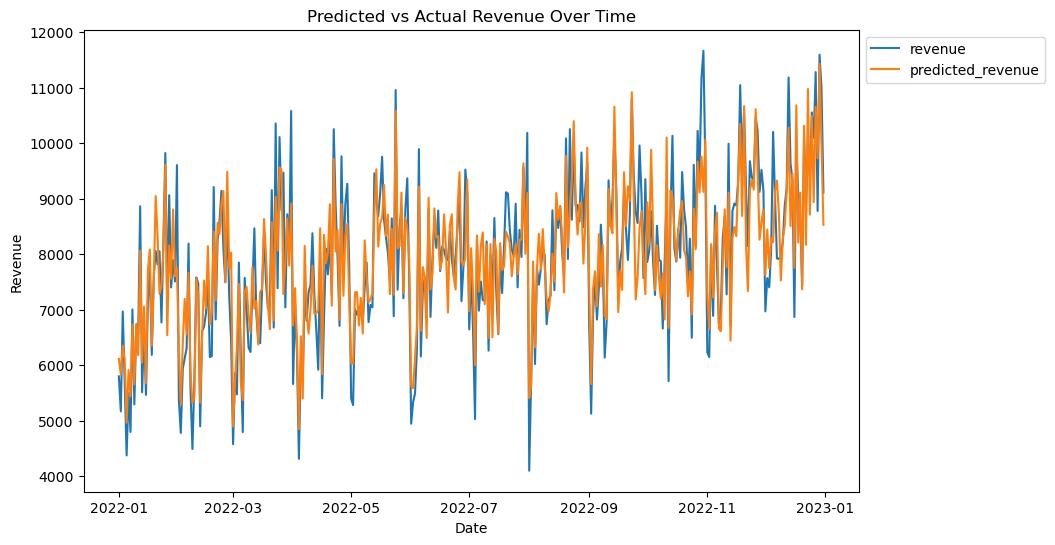

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_df['date'] = pd.to_datetime(data_df['date'])
data_df_tmp = data_df[['date', 'revenue', 'predicted_revenue']]

# Reshape the DataFrame to long format
df_long = data_df_tmp.melt(id_vars='date', var_name='Type', value_name='Revenue')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='date', y='Revenue', hue='Type')
plt.title('Predicted vs Actual Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust as necessary

# plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()


#### Root Mean Square Error (RMSE)

In [19]:
# Get RMSE
predicted_revenue = data_df['predicted_revenue']
actual_revenue = data_df['revenue']
min_revenue = np.min([predicted_revenue, actual_revenue])
max_revenue = np.max([predicted_revenue, actual_revenue])

rmse = np.sqrt(np.mean((np.array(actual_revenue) - np.array(predicted_revenue))**2))
relative_error = rmse/ (max_revenue - min_revenue)
print(f"RMSE: {rmse}, relative error: {relative_error}")

RMSE: 649.1068387561464, relative error: 0.08573098552550638


### ii) Response curves
* This is crucial for marketers to understand the how their money were spent into various channel

943.482 1.88142 867.547
943.635 1.88016 524.184
546.204 1.17956 607.126
231.683 0.849053 468.68
336.685 0.938052 495.095
952.421 1.9004 783.668
287.944 0.916324 538.27
273.131 0.885842 483.767
286.606 0.928982 470.455
943.766 1.87877 306.774
377.472 0.960708 513.509


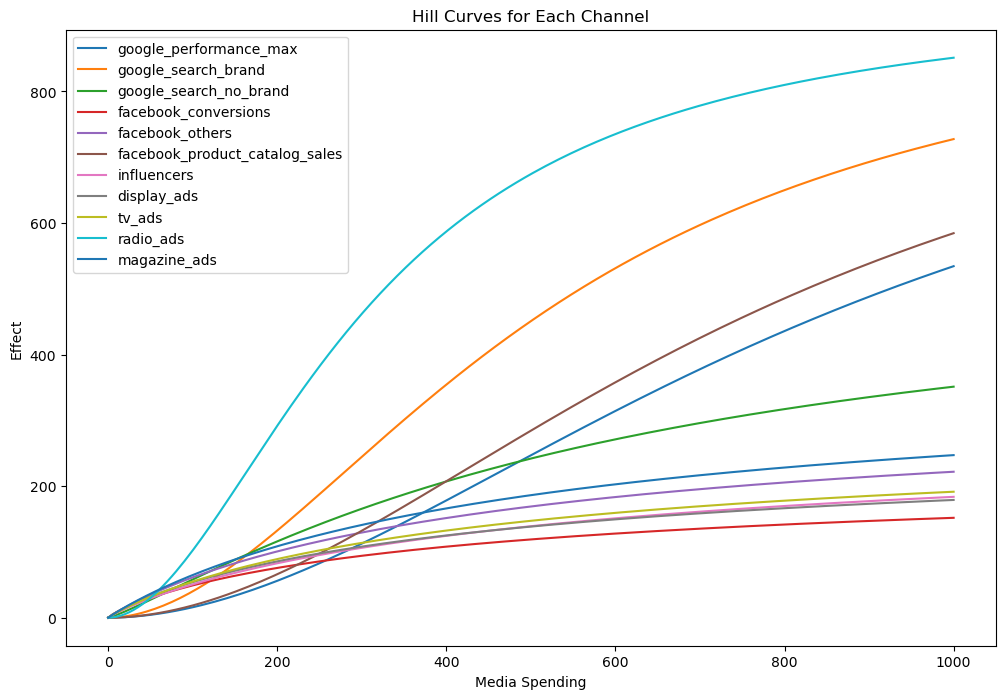

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def hill_function(x, beta, A, B):
    return beta * x**A / (x**A + B**A)

# Define a range of x values (media spending/effort)
x_values = np.linspace(0, 1000, 200)  # Adjust range and resolution as needed

# Plotting Hill curves for each channel
plt.figure(figsize=(12, 8))
medias = config_df[config_df['Category']=='MEDIA'].Variable.tolist()
for media in medias:
    beta = fit_result_dict[f'beta_{media}']
    A = fit_result_dict[f'param_A_{media}']
    B = fit_result_dict[f'param_B_{media}']
    print(beta, A, B)
    y_values = hill_function(x_values, beta, A, B)
    # print(y_values)
    plt.plot(x_values, y_values, label=media)

plt.xlabel('Media Spending')
plt.ylabel('Effect')
plt.title('Hill Curves for Each Channel')
plt.legend()
plt.show()


### iii) Contribution per variable
* Looking at the chart and summary:
    * Base revenue is contributing 63% in average - important for brand equity.
    * Media is contributing 37% to revenue:
        * Google > Facebook > traditional

In [21]:
medias = config_df[config_df['Category']=='MEDIA'].Variable.tolist()
bases = config_df[config_df['Category']=='BASE'].Variable.tolist()
data_df_contribution = data_df.copy()

for base in bases:
    data_df_contribution[f'contribution_{base}'] = fit_result_dict[f'beta_{base}'] * data_df_contribution[base]
for media in medias:
    beta = fit_result_dict[f'beta_{media}']
    A = fit_result_dict[f'param_A_{media}']
    B = fit_result_dict[f'param_B_{media}']
    data_df_contribution[f'contribution_{media}'] = hill_function(data_df_contribution[media], beta, A, B)

In [22]:
data_df_contribution_tmp = data_df_contribution.copy()[['date'] + [col for col in data_df_contribution.copy().columns.tolist() if 'contribution' in col]]
data_df_contribution_tmp['total_contribution'] = data_df_contribution_tmp.select_dtypes('float').sum(axis=1)

numerical_columns = [col for col in data_df_contribution_tmp.columns if col not in ['date', 'total_contribution']]
data_df_contribution_tmp[numerical_columns] = data_df_contribution_tmp[numerical_columns].div(data_df_contribution_tmp['total_contribution'], axis=0)
columns_of_interest = [col for col in data_df_contribution_tmp.columns if col not in ['date', 'total_contribution']]

# Convert the values in these columns to percentages
data_df_contribution_tmp[columns_of_interest] *= 100

# Display the mean values in percentage
percentage_means = data_df_contribution_tmp[columns_of_interest].mean().sort_values(ascending=False)
pd.DataFrame(percentage_means)

,0
contribution_base_revenue,62.241355
contribution_google_performance_max,5.755877
contribution_facebook_product_catalog_sales,5.063053
contribution_radio_ads,4.840407
contribution_google_search_no_brand,4.816524
contribution_google_search_brand,4.644380
contribution_tv_ads,2.894622
contribution_facebook_others,2.325329
contribution_display_ads,2.266322
contribution_magazine_ads,2.219479


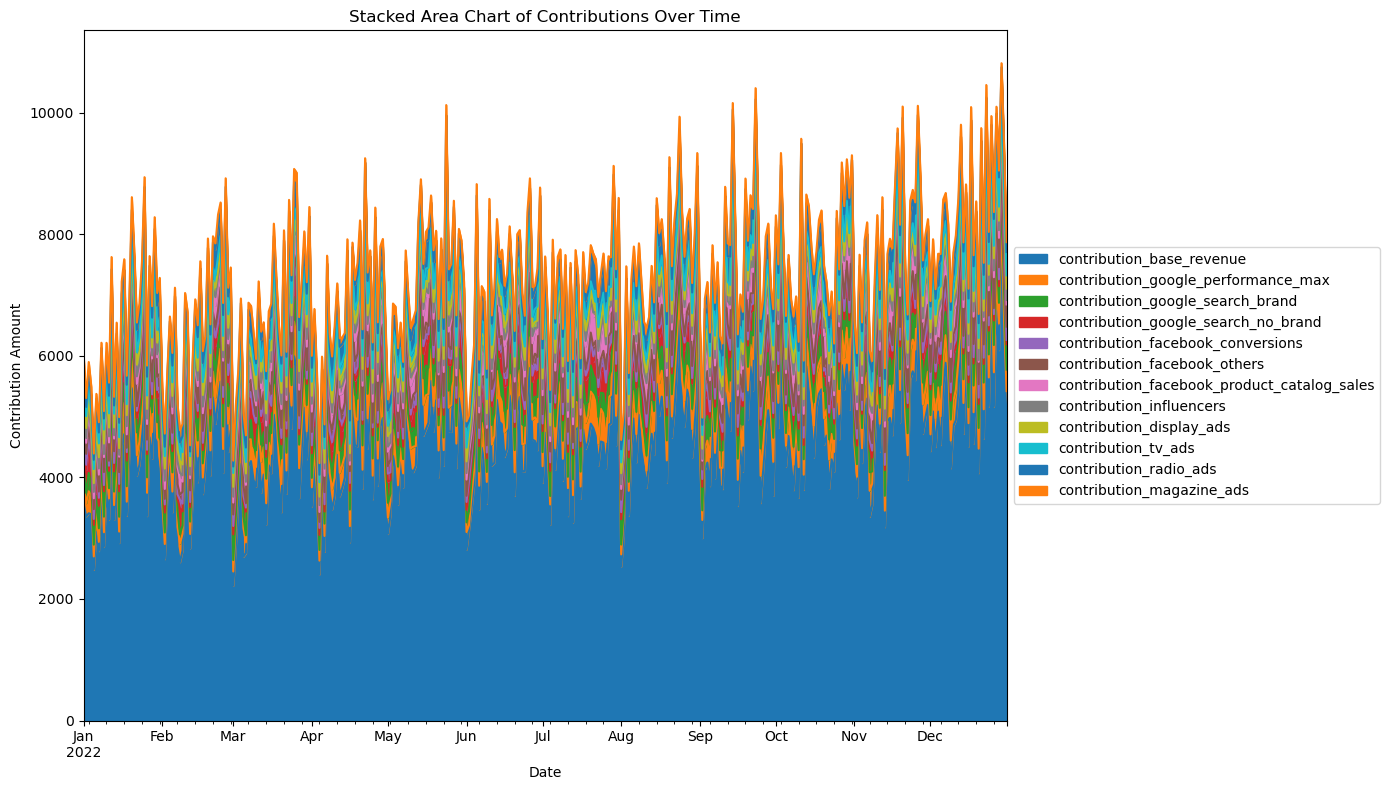

In [23]:
data_df_contribution_tmp = data_df_contribution.copy()[['date'] + [col for col in data_df_contribution.copy().columns.tolist() if 'contribution' in col]]
data_df_contribution_tmp.set_index('date', inplace=True)

plt.figure(figsize=(14, 8))

# Using seaborn's color palette for better distinction
sns.color_palette("tab20", len(data_df_contribution_tmp.columns))

# Stacked plot using seaborn
data_df_contribution_tmp.plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Stacked Area Chart of Contributions Over Time')
plt.xlabel('Date')
plt.ylabel('Contribution Amount')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 2. Quick Demo - Reallocating budgets
* Given the response curves from MMM - running optimization would probably:
    * shifting money from some social media to radio 

## A) Optimization Problem Formulation

### i) Variables
Let $s_i$ be the spend for channel $i$, where $i$ belongs to the set of channels.

### ii) Objective Function
Maximize the sum of KPIs across all channels. The KPI for each channel is a function of the spend $s_i$, and other parameters $\beta_i$, $A_i$, and $B_i$. The objective function can be represented as:
$$
\text{Maximize} \sum_{i} \text{KPI}(s_i, \beta_i, A_i, B_i)
$$
where KPI is defined by the hill_function.

### iii) Constraints
- **Budget Constraint**: The total spend across all channels should not exceed the total average daily budget.
$$
\sum_{i} s_i \leq \text{Total Average Daily Budget}
$$

- **Non-negativity and Upper Bound Constraint**: For each channel, the spend must be non-negative and may have an upper bound (if specified).
$$
0 \leq s_i \leq \text{Upper Bound}_i \, \text{(if an upper bound exists)}
$$

### iv) Parameters
- $\beta_i, A_i, B_i$: Parameters specific to each channel, used in the KPI calculation.
- Total Average Daily Budget: The total budget available for allocation across channels.


In [24]:
medias = config_df[config_df['Category']=='MEDIA'].Variable.tolist()
bases = config_df[config_df['Category']=='BASE'].Variable.tolist()

data_df_tmp = data_df.copy()[[col for col in medias]]
average_daily_budget = data_df_tmp.select_dtypes('float').mean(axis=0)
total_average_daily_budget = average_daily_budget.sum()

print(f"The average_total_budget is {total_average_daily_budget}")

The average_total_budget is 7124.530579915918


In [25]:
import json
with open('fit_result_dict.json', 'r') as f:
    fit_result_dict = json.load(f)

## B) Solving the Pyomo Optimization Model

In [59]:
import pyomo.environ as pyo

average_daily_budget_df = average_daily_budget.reset_index()
average_daily_budget_df.columns = ['channel', 'current_spend']
average_daily_budget_df['bound'] = average_daily_budget_df.apply(lambda x: (0.0, None), axis=1)

# Complete the df with fitted parameters by stan
average_daily_budget_df['beta'] = average_daily_budget_df.apply(lambda x: fit_result_dict[f"beta_{x['channel']}"], axis=1)
average_daily_budget_df['A'] = average_daily_budget_df.apply(lambda x: fit_result_dict[f"param_A_{x['channel']}"], axis=1)
average_daily_budget_df['B'] = average_daily_budget_df.apply(lambda x: fit_result_dict[f"param_B_{x['channel']}"], axis=1)

model = pyo.ConcreteModel()
# Declare pyomo.var inside the dataframe
model.spend = pyo.Var(average_daily_budget_df.index.tolist(), 
                      domain=pyo.NonNegativeReals, 
                      initialize=average_daily_budget_df.current_spend.tolist(), 
                      bounds=average_daily_budget_df.bound.tolist())
average_daily_budget_df['model_spend'] = [model.spend[i] for i in model.spend]

# Declare objective
average_daily_budget_df['model_kpi'] = hill_function(average_daily_budget_df['model_spend'],
                                                      average_daily_budget_df['beta'],
                                                      average_daily_budget_df['A'],
                                                      average_daily_budget_df['B']
                                                     )
# Declare pyomo.constraint inside the dataframe
model.budget_constraint = pyo.Constraint(expr=average_daily_budget_df['model_spend'].sum()<=total_average_daily_budget)

# Declare pyomo.constraint inside the dataframe
model.objective = pyo.Objective(expr=average_daily_budget_df['model_kpi'].sum(), sense=pyo.maximize)
model.objective.pprint()
print(f"KPI with current allocation: {pyo.value(model.objective)}")

result = pyo.SolverFactory('ipopt').solve(model)
print(result['Solver'])
print(f"KPI with optimized allocation: {pyo.value(model.objective)}")

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 943.482*spend[0]**1.88142/((spend[0] + 1e-09)**1.88142 + 337414.1094306333) + 943.635*spend[1]**1.88016/((spend[1] + 1e-09)**1.88016 + 129737.21988238794) + 546.204*spend[2]**1.17956/((spend[2] + 1e-09)**1.17956 + 1918.8648119221148) + 231.683*spend[3]**0.849053/((spend[3] + 1e-09)**0.849053 + 185.23183884010345) + 336.685*spend[4]**0.938052/((spend[4] + 1e-09)**0.938052 + 337.0993962414538) + 952.421*spend[5]**1.9004/((spend[5] + 1e-09)**1.9004 + 316234.0777135049) + 287.944*spend[6]**0.916324/((spend[6] + 1e-09)**0.916324 + 318.0394580913975) + 273.131*spend[7]**0.885842/((spend[7] + 1e-09)**0.885842 + 238.87105954180848) + 286.606*spend[8]**0.928982/((spend[8] + 1e-09)**0.928982 + 303.89335161357127) + 943.766*spend[9]**1.87877/((spend[9] + 1e-09)**1.87877 + 47006.73484204181) + 377.472*spend[10]**0.960708/((spend[10] + 1e-09)**0.960708 + 401.83263503958074)
KPI with 

## C) Suggestions from Optimization Model

<Figure size 1000x600 with 0 Axes>

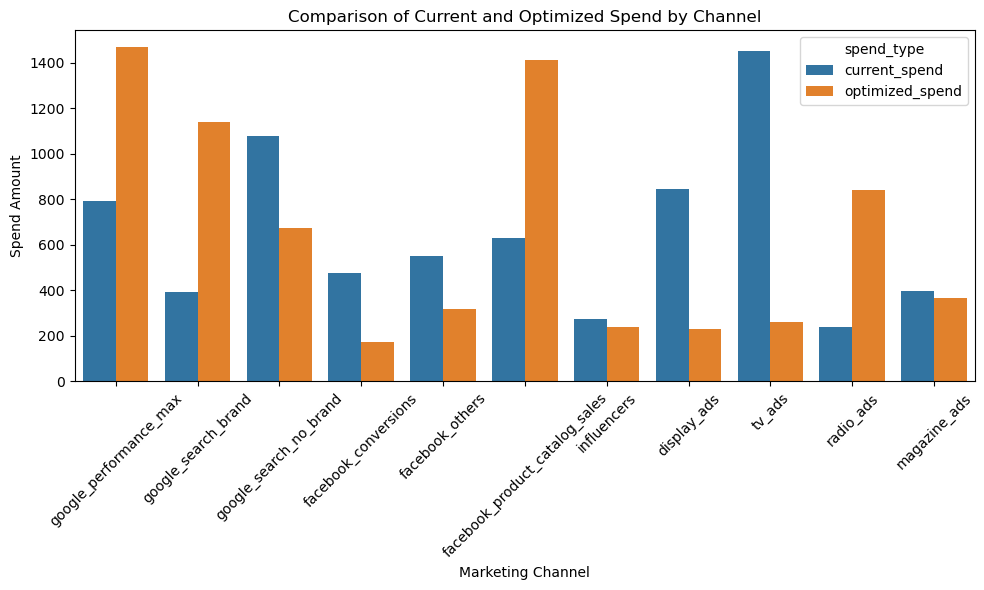

In [68]:
import seaborn as sns

average_daily_budget_df['optimized_spend'] = [model.spend[i].value for i in model.spend]
average_daily_budget_df = average_daily_budget_df[['channel', 'current_spend', 'optimized_spend']]

plt.figure(figsize=(10, 6))

average_daily_budget_df_melted = average_daily_budget_df.melt(id_vars="channel", var_name="spend_type", value_name="amount")

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='amount', hue='spend_type', data=average_daily_budget_df_melted)
plt.title('Comparison of Current and Optimized Spend by Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Spend Amount')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Recommendation:
* Putting more money into **Google**, generating more sales
* Moving moeny from facebook conversions and others, to **catalog sales**.
* Reduce spending on **display and TV**
* Putting more money into **radio**